# DSM150 - Neural Networks Coursework 2

## Introduction

Introduced to the major public ChatGPT quickly demonstrated the enormous potential of Large Language Models(LLMs). This marked the beginning of a new era where the concepts of neural networks left academic circles, becoming a topic of conversations of everyday life. Subsequently, these LLMs introduced the capability of image recognition. Users are able to upload images and let them be analyzed and described by LLMs, which further underlined the versatility and potential of neural networks. Today, Convolutional Neural Networks have found extensive application across various fields. From medical imaging, such as fraction detection in x-ray images, to the 'simple' object detection on smartphones. The impact of CNNs is both profound and pervasive. This coursework report seeks to explore the practical realization of CNNs, as presented in "Deep Learning with Python", highlighting the indispensable role in the digital age. 


### Classification Task Overview

Following to the introduction, this section aims to define the specific classification task that forms the core focus of the coursework. The objective is to develop an CNN model capable to accurately classify images of animals into five distinct category, each representing a different type of animal. The animals for the classification tasks are as follows:
- Category 1: Cat
- Category 2: Dog
- Category 3: Elephant
- Category 4: Horse
- Category 5: Lion

The task is designed ti challenge the models ability to discem and learn from the unique feature characteristics of each animal type, ranging from texture and shape to size and environmental context. 





## Dataset Description

The dataset that is used for the classification task holds images representing five distinct animal categories ( also see 'Classification Task Overview'). These datset was sourced from Kaggle and can be found under the name 'Animals - Animals Classification Dataset [1]'. It contains 15'000 pictures of animals, which has been collected from Google Images. The Dataset is splitted in training images and validation images. The validation sets holds 300 images for each animal type. This roughly represents the relative size of 11% of the training images.

## Course Work Approach

This course work adopts a structured, iterative approach to explore, implement and refine Convolutional Neural Networks (CNNs) for an image recognitions task. The approach can be subdivided into distinct phases, each designed to build-up on the previous steps.  The process is as follows:

1. Exploring the Images:
- Show Images: A subset of the dataset will be visually examined to understand the variety and characteristics of the data. This step is designed to create an understanding of potential challenges in image recognition tasks, such as image orientation and lighting.
- Count of Images -> Class Distribution: This step is designed to picture the class distribution of target classes. This step is supposed to detect any class imbalances. A balanced dataset is essential to create a robust and unbiased model.

2. Loading and Preparation:
- This phase covers the image loading and preparation for the model training. This tasks covers preprocessing steps like image normalizing and rescaling the data, implementing an image generator and applying data augmentation techniques.

3. Define a Base Model:
- A baseline CNN is created and trained on the dataset prepared on the previous step. The model is supposed to serve as a reference in terms of performance and accuracy to identify areas of improvement.

4. Evaluate Base Model:
- Print Standard Parameters: Commonly parameters will be plotted such as trainings and validation accuracy in relation to observe the different training stages of the model. 
- Print Confusion Matrix: The performance of the baseline model will be evaluated by creating a confusion matrix, which gives insights to the models accuracy, recall and precision.

5. Structured Approach to improve Base Model:
- A systematic approach will be employed to  iteratively improve the base model. This involves changes in the architectures.

6. Using a Pretraine Convolutional Network:
- To further discover different techniques, a pretrained CNN will be incorporated. This approach will a allow the model to benefit from features learned on  vast amount of pictures and objects, aiming to improve the generalization capabilities. 

7. Visualizing Structures:
- Finally, the internal structures and features learned by the CNN will be visualized. This step is crucial for understanding how the model interprets and processes image data, providing valuable insights into its decision-making process.

## 1. Exploring the Images:

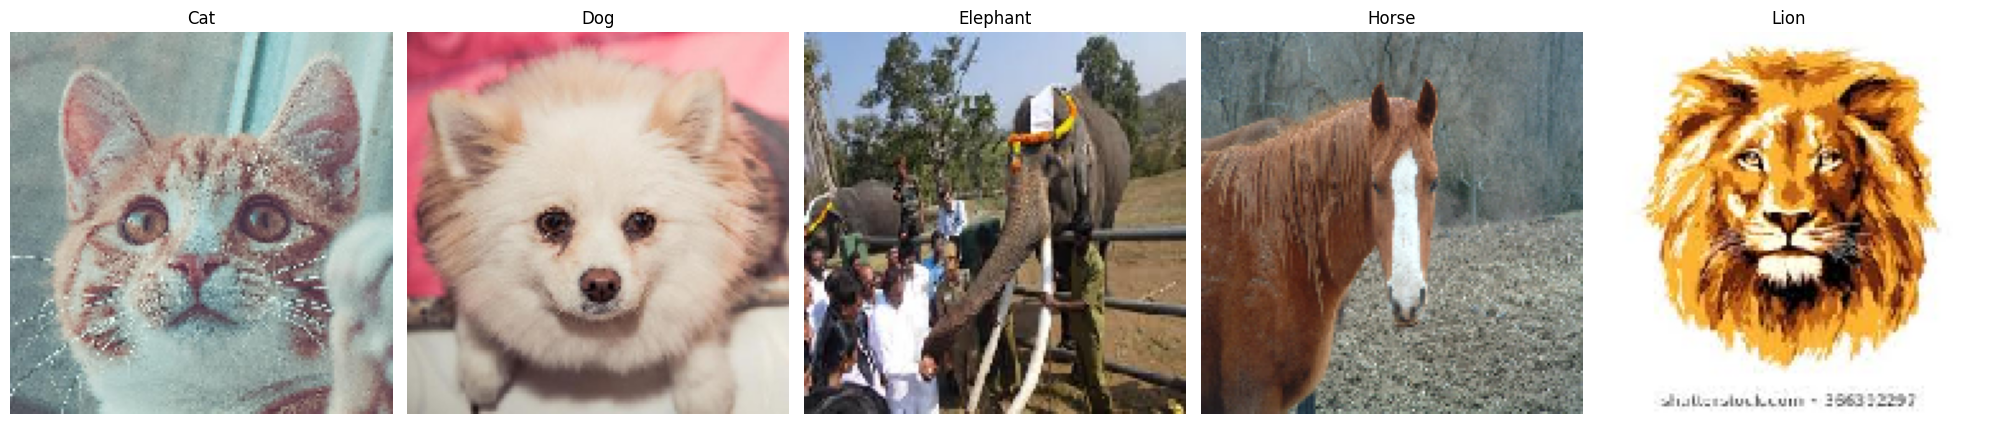

In [1]:
import os, random
from keras.preprocessing import image
import matplotlib.pyplot as plt

dir_base_train= './data/animals/train/'
dir_train_cat= os.path.join(dir_base_train,'cat')
dir_train_dog= os.path.join(dir_base_train,'dog')
dir_train_elephant= os.path.join(dir_base_train,'elephant')
dir_train_horse= os.path.join(dir_base_train,'horse')
dir_train_lion= os.path.join(dir_base_train,'lion')

cat_path_img= os.path.join(dir_train_cat, random.choice(os.listdir(dir_train_cat)))
dog_path_img= os.path.join(dir_train_dog,random.choice(os.listdir(dir_train_dog)))
elephant_path_img= os.path.join(dir_train_elephant,random.choice(os.listdir(dir_train_elephant)))
horse_path_img= os.path.join(dir_train_horse, random.choice(os.listdir(dir_train_horse)))
lion_path_img= os.path.join(dir_train_lion, random.choice(os.listdir(dir_train_lion)))

cat_img = image.img_to_array(image.load_img(cat_path_img, target_size=(150,150)))
dog_img = image.img_to_array(image.load_img(dog_path_img, target_size=(150,150)))
elephant_img = image.img_to_array(image.load_img(elephant_path_img, target_size=(150,150)))
horse_img = image.img_to_array(image.load_img(horse_path_img, target_size=(150,150)))
lion_img = image.img_to_array(image.load_img(lion_path_img, target_size=(150,150)))

# Set up the matplotlib figure and axes, specifying the figure size and the grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

# List of the images
images = [cat_img, dog_img, elephant_img, horse_img, lion_img]

# Titles for each subplot
titles = ['Cat', 'Dog', 'Elephant', 'Horse', 'Lion']

# Plot each image
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(images[i] / 255.)  # Normalize the image to [0,1] since matplotlib expects floats in [0,1] or integers in [0, 255]
    ax.set_title(titles[i])  # Set a title for each subplot
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the figure with the images


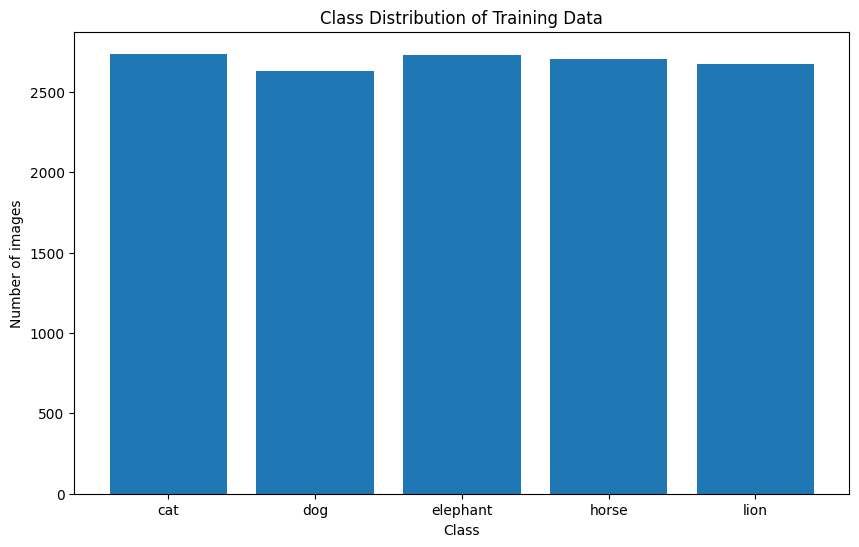

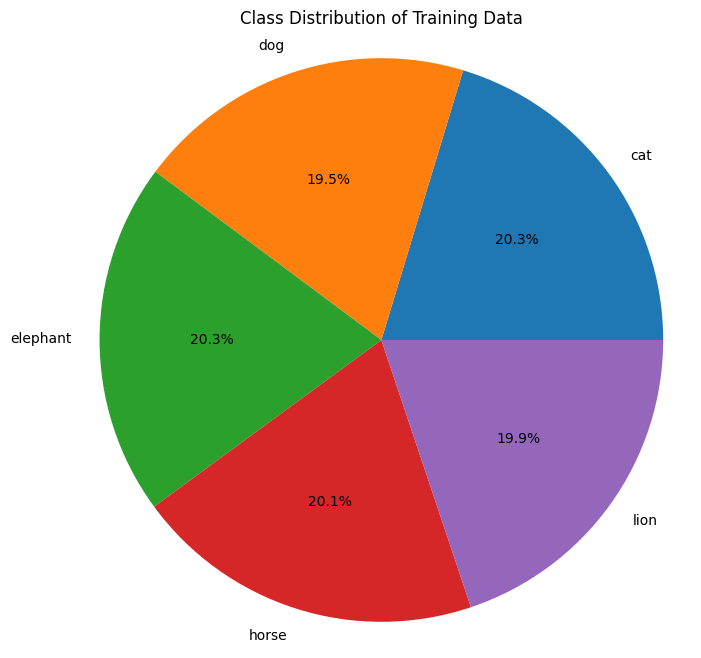

In [2]:
# Class distributions Images
classes = ['cat', 'dog', 'elephant', 'horse', 'lion']
class_counts = {}

for class_name in classes:
    dir_path = os.path.join(dir_base_train, class_name)
    class_counts[class_name] = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

# Data
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution of Training Data')
plt.show()

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of Training Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

On the above charts can be seen, that the data is almost equally distributed. Only minor differences can be stopped between each class. As a result there is not need to take care of under- or overrepresented classes in the process of data preparation. There is no risk of a bias caused by an imbalanced dataset.

# 2. Loading and Preparation

The used dateset was downloaded from Kaggel.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

In [4]:
# define base directory where pictures stored
dir_base_train= './data/animals/train/'
dir_base_val= './data/animals/val/'

In [33]:
# import lib for Image Generator
#from keras.preprocessing.image import ImageDataGenerator

# rescale images by 1/255
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)

# read img from target dirs, resize image to 150x150, 
train_generator= train_datagen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True
    
)


Found 13474 images belonging to 5 classes.


In [34]:
val_generator= val_datagen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1497 images belonging to 6 classes.


In [35]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (32, 150, 150, 3)
Labels batch shape: (32, 5)


In [36]:
#def generate_file_path_labels(base_dir):
#    categories= ['train', 'val']
#    train_file_paths_labels= []
#    val_file_paths_labels= []

#    for category in categories:

        # define path to the basedir
        #base_dir= os.path.join(data_dir, category)

        #for animal_name in os.listdir(base_dir):
        #    animal_dir=  os.path.join(base_dir, animal_name)
        #    if os.path.isdir(animal_dir):
         #       for file_name in os.listdir(animal_dir):
          #          file_path= os.path.join(animal_dir, file_name)
#
 #                   if category == 'train':
  #                      train_file_paths_labels.append((animal_name, file_path))
   #                 if category == 'val':
                       # val_file_paths_labels.append((animal_name, file_path))
#
#
#
 #   return train_file_paths_labels, val_file_paths_labels

In [9]:
#data_dir= './data/animals'
#train_file_paths_labels, val_file_paths_labels= generate_file_path_labels(data_dir)

In [10]:
#print(train_file_paths_labels[:10])
#print(val_file_paths_labels[:10])

The directory containing the dataset consists of three folders: 'inf' , 'train' and 'test'. Obviously the two of three folders holding trainings and test data. The test and trainings folder hold additional 5 subdirectory divided into animals name. The dir 'inf' holding 5 pictures on the next child level providing some informative representations of the animals used in this dataset.

# 2. Create a Dataset of Images

In [11]:
#import tensorflow as tf

In [12]:
#def decode_image(img, img_height= 150, img_width= 150):
#    # convert the compressed string to a 3D uint8 tensort
#    img= tf.image.decode_jpeg(img, channels= 3)
#    # resize image to specific size
#    return tf.image.resize(img, [img_height, img_width])

In [13]:
#def process_path(label, file_path):
#    # load raw data from the file as string
#    img= tf.io.read_file(file_path)
#    img= decode_image(img)
#    return img, label

In [14]:
#def prepare_dataset(file_paths_labels, img_height= 150, img_width= 150, batch_size= 32):
#    # split labels and file paths into seperate lists
#    labels, file_paths= zip(*[(label, fp) for label, fp in file_paths_labels])
#    labels= list(labels)
#    file_paths= list(file_paths)

    # create dataset of filepaths and labels
    #ds= tf.data.Dataset.from_tensor_slices((labels, file_paths))

    # process file paths to load images, convert labels into one hot encoding
    #ds= ds.map(lambda y,x : process_path(tf.one_hot(y, depth= len(set(labels))), x))

    # batch the data
    #ds= ds.batch(batch_size)

    #return ds

In [15]:
# mapping labels to an index
#label_to_index= {
#    'cat': 0,
#    'dog': 1,
#    'elephant': 2,
#    'horse': 3,
#    'lion': 4
#}

In [16]:
# convert labels to integers
#train_file_paths_labels= [(label_to_index[label], fp) for label, fp in train_file_paths_labels]
#val_file_paths_labels= [(label_to_index[label], fp) for label, fp in val_file_paths_labels]

In [17]:
# calling prepare dataset function
#train_dataset= prepare_dataset(train_file_paths_labels, img_height= 150, img_width= 150, batch_size=32)


In [18]:
#val_dataset= prepare_dataset(train_file_paths_labels, img_height= 150, img_width= 150, batch_size=32)

In [19]:
#print(train_dataset)

In [21]:
input_shape= (150, 150, 3)

In [43]:
# intializing model
model= models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
steps_per_epoch= train_generator.samples // train_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

In [47]:
len(train_generator)

422

In [48]:
history= model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 100,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/100
421/421 [==============================] - ETA: 0s - loss: 0.9015 - accuracy: 0.6448

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/9_/1_9hr2h94qv77qnhdldk7_9h0000gn/T/ipykernel_51662/1280299716.py", line 1, in <module>
      history= model.fit(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/opt/anaconda3/envs/dsm150_cw2_conda/lib/python3.8/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,5] labels_size=[32,6]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_6978]

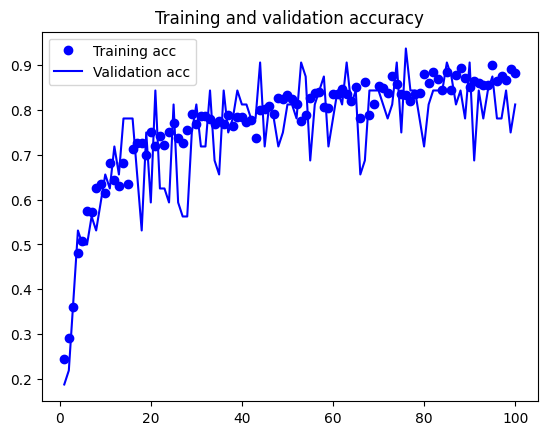

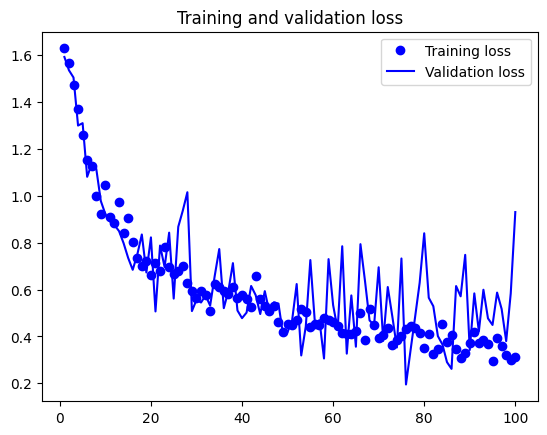

In [28]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Applying Data Augmentation

In [42]:
train_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [43]:
val_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [44]:
train_aug_generator= train_aug_img_data_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True
)

Found 13474 images belonging to 5 classes.


In [46]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True  
)

Found 1497 images belonging to 5 classes.


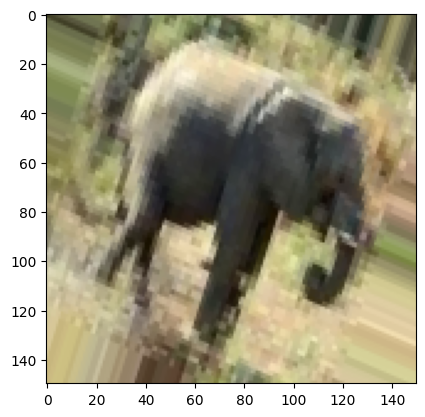

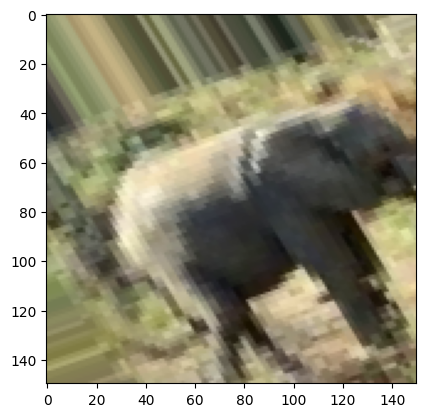

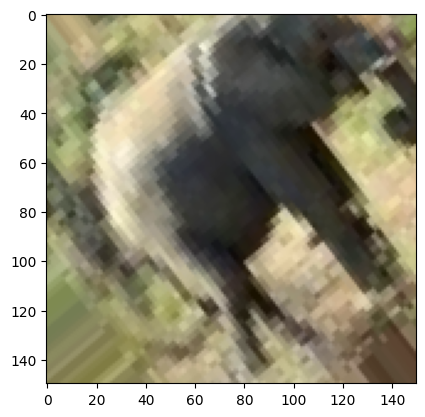

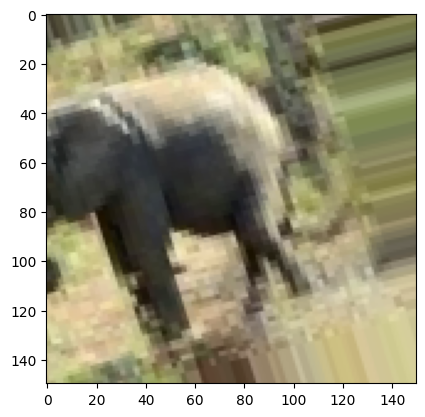

In [78]:
# displaying some random pics
from keras.preprocessing import image

fnames= [os.path.join('./data/animals/train/elephant', fname) for fname in os.listdir('./data/animals/train/elephant') ]

img_path= fnames[3]

img= image.load_img(img_path, target_size=(150,150))

x= image.img_to_array(img)
x= x.reshape((1,) + x.shape)

i=0

for batch in train_aug_img_data_gen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot= plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
    
plt.show()

In [123]:
# intializing model
model_da= models.Sequential()
model_da.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Conv2D(64, (3,3), activation= 'relu'))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Conv2D(128, (3,3), activation= 'relu'))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Conv2D(256, (3,3), activation= 'relu'))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Flatten())
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Dense(64, activation='relu'))
model_da.add(layers.Dense(128, activation='relu'))
model_da.add(layers.Dense(5, activation='softmax'))

In [124]:
model_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_da.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
steps_per_epoch= len(train_aug_generator) // 32
validation_steps= len(val_aug_generator) // 32

In [126]:
history_da= model_da.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 150,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/150
13/13 [==============================] - 2s 164ms/step - loss: 1.6291 - accuracy: 0.2163 - val_loss: 1.6096 - val_accuracy: 0.3125
Epoch 2/150
13/13 [==============================] - 2s 154ms/step - loss: 1.6088 - accuracy: 0.2139 - val_loss: 1.6095 - val_accuracy: 0.1562
Epoch 3/150
13/13 [==============================] - 2s 149ms/step - loss: 1.6001 - accuracy: 0.2572 - val_loss: 1.5836 - val_accuracy: 0.2812
Epoch 4/150
13/13 [==============================] - 2s 152ms/step - loss: 1.5762 - accuracy: 0.2548 - val_loss: 1.5233 - val_accuracy: 0.3750
Epoch 5/150
13/13 [==============================] - 2s 156ms/step - loss: 1.5202 - accuracy: 0.3293 - val_loss: 1.4695 - val_accuracy: 0.4062
Epoch 6/150
13/13 [==============================] - 2s 151ms/step - loss: 1.4927 - accuracy: 0.3149 - val_loss: 1.4926 - val_accuracy: 0.3438
Epoch 7/150
13/13 [==============================] - 2s 155ms/step - loss: 1.4822 - accuracy: 0.3798 - val_loss: 1.4456 - val_accuracy: 0.2812

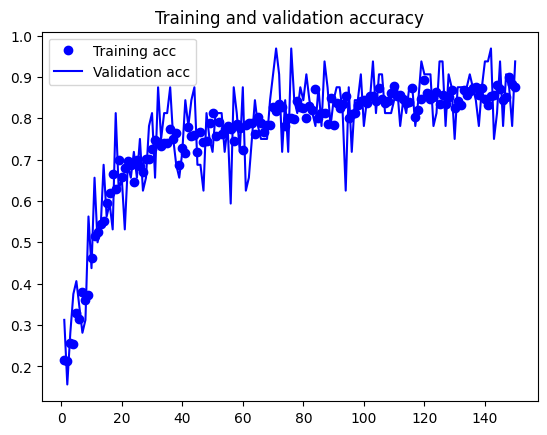

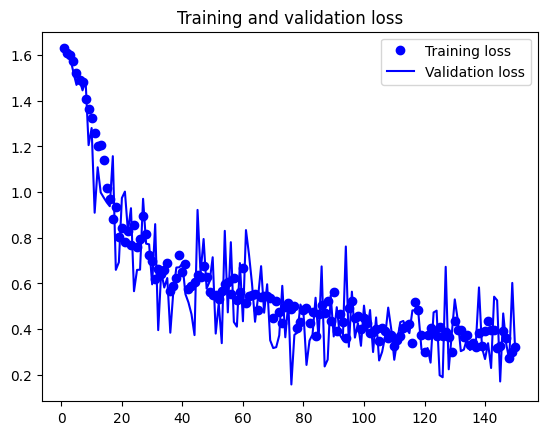

In [127]:
acc= history_da.history['accuracy']
val_acc= history_da.history['val_accuracy']
loss= history_da.history['loss']
val_loss= history_da.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [131]:
# save the model
model_da.save('animals.keras')

# Using a pretrained convolutional Model


In [129]:
from keras.applications import VGG16

In [130]:
conv_base= VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [110]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [132]:
model_cbase_aug= models.Sequential()
model_cbase_aug.add(conv_base)
model_cbase_aug.add(layers.Flatten())
model_cbase_aug.add(layers.Dense(256, activation='relu'))
model_cbase_aug.add(layers.Dense(5, activation='softmax'))



In [133]:
model_cbase_aug.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 8192)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               2097408   
                                                                 
 dense_38 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 16813381 (64.14 MB)
Trainable params: 16813381 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
print(f'Number of trainable wieghts: {len(model_cbase_aug.trainable_weights)}')

Number of trainable wieghts: 30


In [136]:
conv_base.trainable = False

In [137]:
print(f'Number of trainable weights after freezing model base: {len(model_cbase_aug.trainable_weights)}')

Number of trainable weights after freezing model base: 4


In [ ]:
steps_per_epoch= len(train_aug_generator) // 32
validation_steps= len(val_aug_generator) // 32

In [138]:
model_cbase_aug.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

In [139]:
history_model_cbase_aug = model_cbase_aug.fit(
    train_aug_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 100,
    validation_data= val_aug_generator,
    validation_steps= validation_steps
)

Epoch 1/100
13/13 [==============================] - 10s 745ms/step - loss: 1.9850 - accuracy: 0.3582 - val_loss: 1.4135 - val_accuracy: 0.3750
Epoch 2/100
13/13 [==============================] - 10s 731ms/step - loss: 0.8273 - accuracy: 0.6683 - val_loss: 0.5509 - val_accuracy: 0.8125
Epoch 3/100
13/13 [==============================] - 10s 740ms/step - loss: 0.7477 - accuracy: 0.7091 - val_loss: 0.3827 - val_accuracy: 0.7812
Epoch 4/100
13/13 [==============================] - 10s 729ms/step - loss: 0.6243 - accuracy: 0.7500 - val_loss: 0.6020 - val_accuracy: 0.7188
Epoch 5/100
13/13 [==============================] - 10s 739ms/step - loss: 0.5842 - accuracy: 0.7764 - val_loss: 0.6971 - val_accuracy: 0.6875
Epoch 6/100
13/13 [==============================] - 10s 731ms/step - loss: 0.6617 - accuracy: 0.7260 - val_loss: 0.6956 - val_accuracy: 0.7188
Epoch 7/100
13/13 [==============================] - 10s 771ms/step - loss: 0.6154 - accuracy: 0.7596 - val_loss: 0.5433 - val_accuracy:

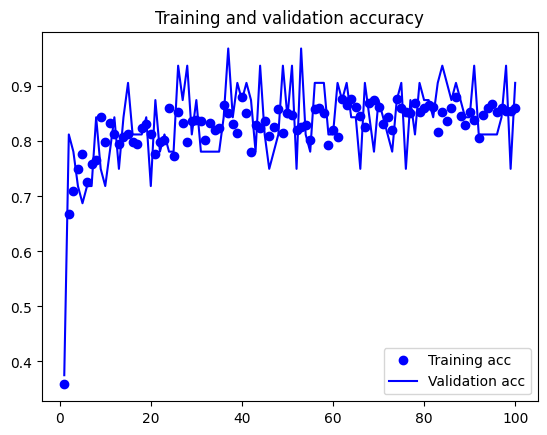

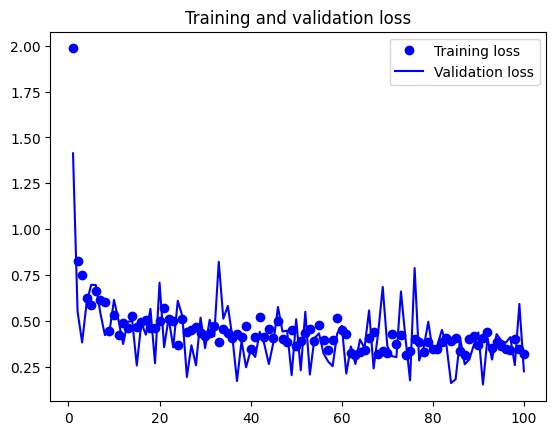

In [140]:
acc= history_model_cbase_aug.history['accuracy']
val_acc= history_model_cbase_aug.history['val_accuracy']
loss= history_model_cbase_aug.history['loss']
val_loss= history_model_cbase_aug.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# References:

[1] Kaggle - Animals: Animals Classification Dataset; Url: https://www.kaggle.com/datasets/antobenedetti/animals/